https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/cross_validation.html

In [ ]:
# !pip install neuralforecast

In [1]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
from utilsforecast.plotting import plot_series

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

from neuralforecast.auto import AutoNHITS, AutoRNN, AutoLSTM, AutoGRU, AutoTCN, AutoDeepAR, AutoDilatedRNN, AutoBiTCN
from neuralforecast.auto import AutoMLP, AutoNBEATS, AutoNBEATSx, AutoDLinear, AutoNLinear, AutoTiDE, AutoDeepNPTS
from neuralforecast.auto import AutoTFT, AutoVanillaTransformer, AutoInformer, AutoAutoformer, AutoFEDformer
from neuralforecast.auto import AutoPatchTST, AutoiTransformer, AutoTimesNet

In [2]:
import logging
import os
import warnings

warnings.filterwarnings('ignore')

# Change the default logging directory
os.environ["LIGHTNING_LOGS_DIR"] = "/workdir/my_lightning_logs"  # Or any other desired path

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [ ]:
# Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
# Y_df

In [3]:
folder = './datasets/crypto/hourly/'

df = pd.read_csv(folder + 'dataset.csv')
df

,Datetime,Real,BTC-USD,ETH-USD,XRP-USD,BNB-USD,SOL-USD,WBTC-USD,LINK-USD,AVAX-USD,...,FIL-USD,KCS-USD,MKR-USD,NEXO-USD,QNT-USD,WETH-USD.1,INJ-USD,WBNB-USD,RAY-USD,RETH-USD
0,2023-04-30 00:00:00+00:00,True,29169.316406,1900.032837,0.475706,321.236664,23.166382,29208.886719,7.159136,17.370535,...,5.522918,8.109016,703.833801,0.710913,117.384354,1901.919189,8.096745,321.490173,0.236299,2031.291992
1,2023-04-30 01:00:00+00:00,True,29125.832031,1895.867554,0.475287,320.977600,23.069485,29171.156250,7.142947,17.338963,...,5.537733,8.089770,700.223572,0.710938,116.863853,1898.783813,8.052805,321.081024,0.236342,2027.935059
2,2023-04-30 02:00:00+00:00,True,29195.710938,1899.928589,0.475936,321.625366,23.085386,29161.160156,7.151052,17.316568,...,5.539894,8.114614,700.447998,0.711593,116.848755,1898.285400,8.111716,321.353119,0.236173,2027.361450
3,2023-04-30 03:00:00+00:00,True,29186.826172,1896.305054,0.475193,321.040375,23.177994,29169.595703,7.145714,17.323233,...,5.540592,8.101644,699.074829,0.714947,116.795265,1897.240967,7.923522,321.055359,0.236345,2027.302368
4,2023-04-30 04:00:00+00:00,True,29223.425781,1899.288696,0.475895,321.807983,23.141769,29210.748047,7.162411,17.353481,...,5.550647,8.106717,701.785400,0.707884,117.208046,1898.767334,7.977498,321.626404,0.236086,2028.678101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,2025-04-28 20:00:00+00:00,True,94516.515625,1787.305664,2.289529,603.940735,147.079041,94425.320312,14.841893,21.864857,...,2.777683,10.608781,1496.026367,1.228483,75.665146,1787.755493,10.020804,604.225464,2.915694,2032.736694
17517,2025-04-28 21:00:00+00:00,True,94542.062500,1791.004883,2.299575,605.240601,147.679153,94439.781250,14.906114,21.787466,...,2.770784,10.620269,1504.648926,1.211753,75.757607,1788.387695,10.028238,604.687561,2.932788,2030.161377
17518,2025-04-28 22:00:00+00:00,True,94852.492188,1802.009521,2.301223,605.640686,148.054123,94672.109375,14.993342,21.852861,...,2.773329,10.630237,1513.820190,1.211508,75.782051,1795.985962,10.063803,605.381592,2.950394,2031.017456
17519,2025-04-28 23:00:00+00:00,True,94945.523438,1797.178467,2.295905,605.785461,147.787842,94815.351562,15.046570,21.803116,...,2.761980,10.629302,1514.007324,1.210272,75.797020,1796.907593,10.018976,605.529358,2.936628,2031.231567


In [4]:
date_column_name = df.columns[0]
date_format = '%Y-%m-%d' if date_column_name.lower() == 'date' else '%Y-%m-%d %H:%M:%S'

date_column_name, date_format

('Datetime', '%Y-%m-%d %H:%M:%S')

In [5]:
# Converter a coluna para datetime removendo o fuso horário
if date_column_name.lower() == 'date':
    df[date_column_name] = pd.to_datetime(df[date_column_name])
else:
    df[date_column_name] = pd.to_datetime(df[date_column_name]).dt.tz_convert(None)

df

,Datetime,Real,BTC-USD,ETH-USD,XRP-USD,BNB-USD,SOL-USD,WBTC-USD,LINK-USD,AVAX-USD,...,FIL-USD,KCS-USD,MKR-USD,NEXO-USD,QNT-USD,WETH-USD.1,INJ-USD,WBNB-USD,RAY-USD,RETH-USD
0,2023-04-30 00:00:00,True,29169.316406,1900.032837,0.475706,321.236664,23.166382,29208.886719,7.159136,17.370535,...,5.522918,8.109016,703.833801,0.710913,117.384354,1901.919189,8.096745,321.490173,0.236299,2031.291992
1,2023-04-30 01:00:00,True,29125.832031,1895.867554,0.475287,320.977600,23.069485,29171.156250,7.142947,17.338963,...,5.537733,8.089770,700.223572,0.710938,116.863853,1898.783813,8.052805,321.081024,0.236342,2027.935059
2,2023-04-30 02:00:00,True,29195.710938,1899.928589,0.475936,321.625366,23.085386,29161.160156,7.151052,17.316568,...,5.539894,8.114614,700.447998,0.711593,116.848755,1898.285400,8.111716,321.353119,0.236173,2027.361450
3,2023-04-30 03:00:00,True,29186.826172,1896.305054,0.475193,321.040375,23.177994,29169.595703,7.145714,17.323233,...,5.540592,8.101644,699.074829,0.714947,116.795265,1897.240967,7.923522,321.055359,0.236345,2027.302368
4,2023-04-30 04:00:00,True,29223.425781,1899.288696,0.475895,321.807983,23.141769,29210.748047,7.162411,17.353481,...,5.550647,8.106717,701.785400,0.707884,117.208046,1898.767334,7.977498,321.626404,0.236086,2028.678101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,2025-04-28 20:00:00,True,94516.515625,1787.305664,2.289529,603.940735,147.079041,94425.320312,14.841893,21.864857,...,2.777683,10.608781,1496.026367,1.228483,75.665146,1787.755493,10.020804,604.225464,2.915694,2032.736694
17517,2025-04-28 21:00:00,True,94542.062500,1791.004883,2.299575,605.240601,147.679153,94439.781250,14.906114,21.787466,...,2.770784,10.620269,1504.648926,1.211753,75.757607,1788.387695,10.028238,604.687561,2.932788,2030.161377
17518,2025-04-28 22:00:00,True,94852.492188,1802.009521,2.301223,605.640686,148.054123,94672.109375,14.993342,21.852861,...,2.773329,10.630237,1513.820190,1.211508,75.782051,1795.985962,10.063803,605.381592,2.950394,2031.017456
17519,2025-04-28 23:00:00,True,94945.523438,1797.178467,2.295905,605.785461,147.787842,94815.351562,15.046570,21.803116,...,2.761980,10.629302,1514.007324,1.210272,75.797020,1796.907593,10.018976,605.529358,2.936628,2031.231567


In [6]:
# pure pandas version (faster, more memory-friendly)
def convert_nixtla(df):
  # Convert from wide to long format
  df_long = df.melt(id_vars=[date_column_name], var_name="ticker", value_name="price")

  # Rename columns for Nixtla’s long format and return
  return df_long.rename(columns={date_column_name: "ds", "ticker": "unique_id", "price": "y"})

In [7]:
Y_df = convert_nixtla(df.drop('Real', axis=1))
Y_df

,ds,unique_id,y
0,2023-04-30 00:00:00,BTC-USD,29169.316406
1,2023-04-30 01:00:00,BTC-USD,29125.832031
2,2023-04-30 02:00:00,BTC-USD,29195.710938
3,2023-04-30 03:00:00,BTC-USD,29186.826172
4,2023-04-30 04:00:00,BTC-USD,29223.425781
...,...,...,...
630751,2025-04-28 20:00:00,RETH-USD,2032.736694
630752,2025-04-28 21:00:00,RETH-USD,2030.161377
630753,2025-04-28 22:00:00,RETH-USD,2031.017456
630754,2025-04-28 23:00:00,RETH-USD,2031.231567


In [ ]:
# Y_df = Y_df.query("unique_id == 'BTC-USD'")#[:700]
# Y_df

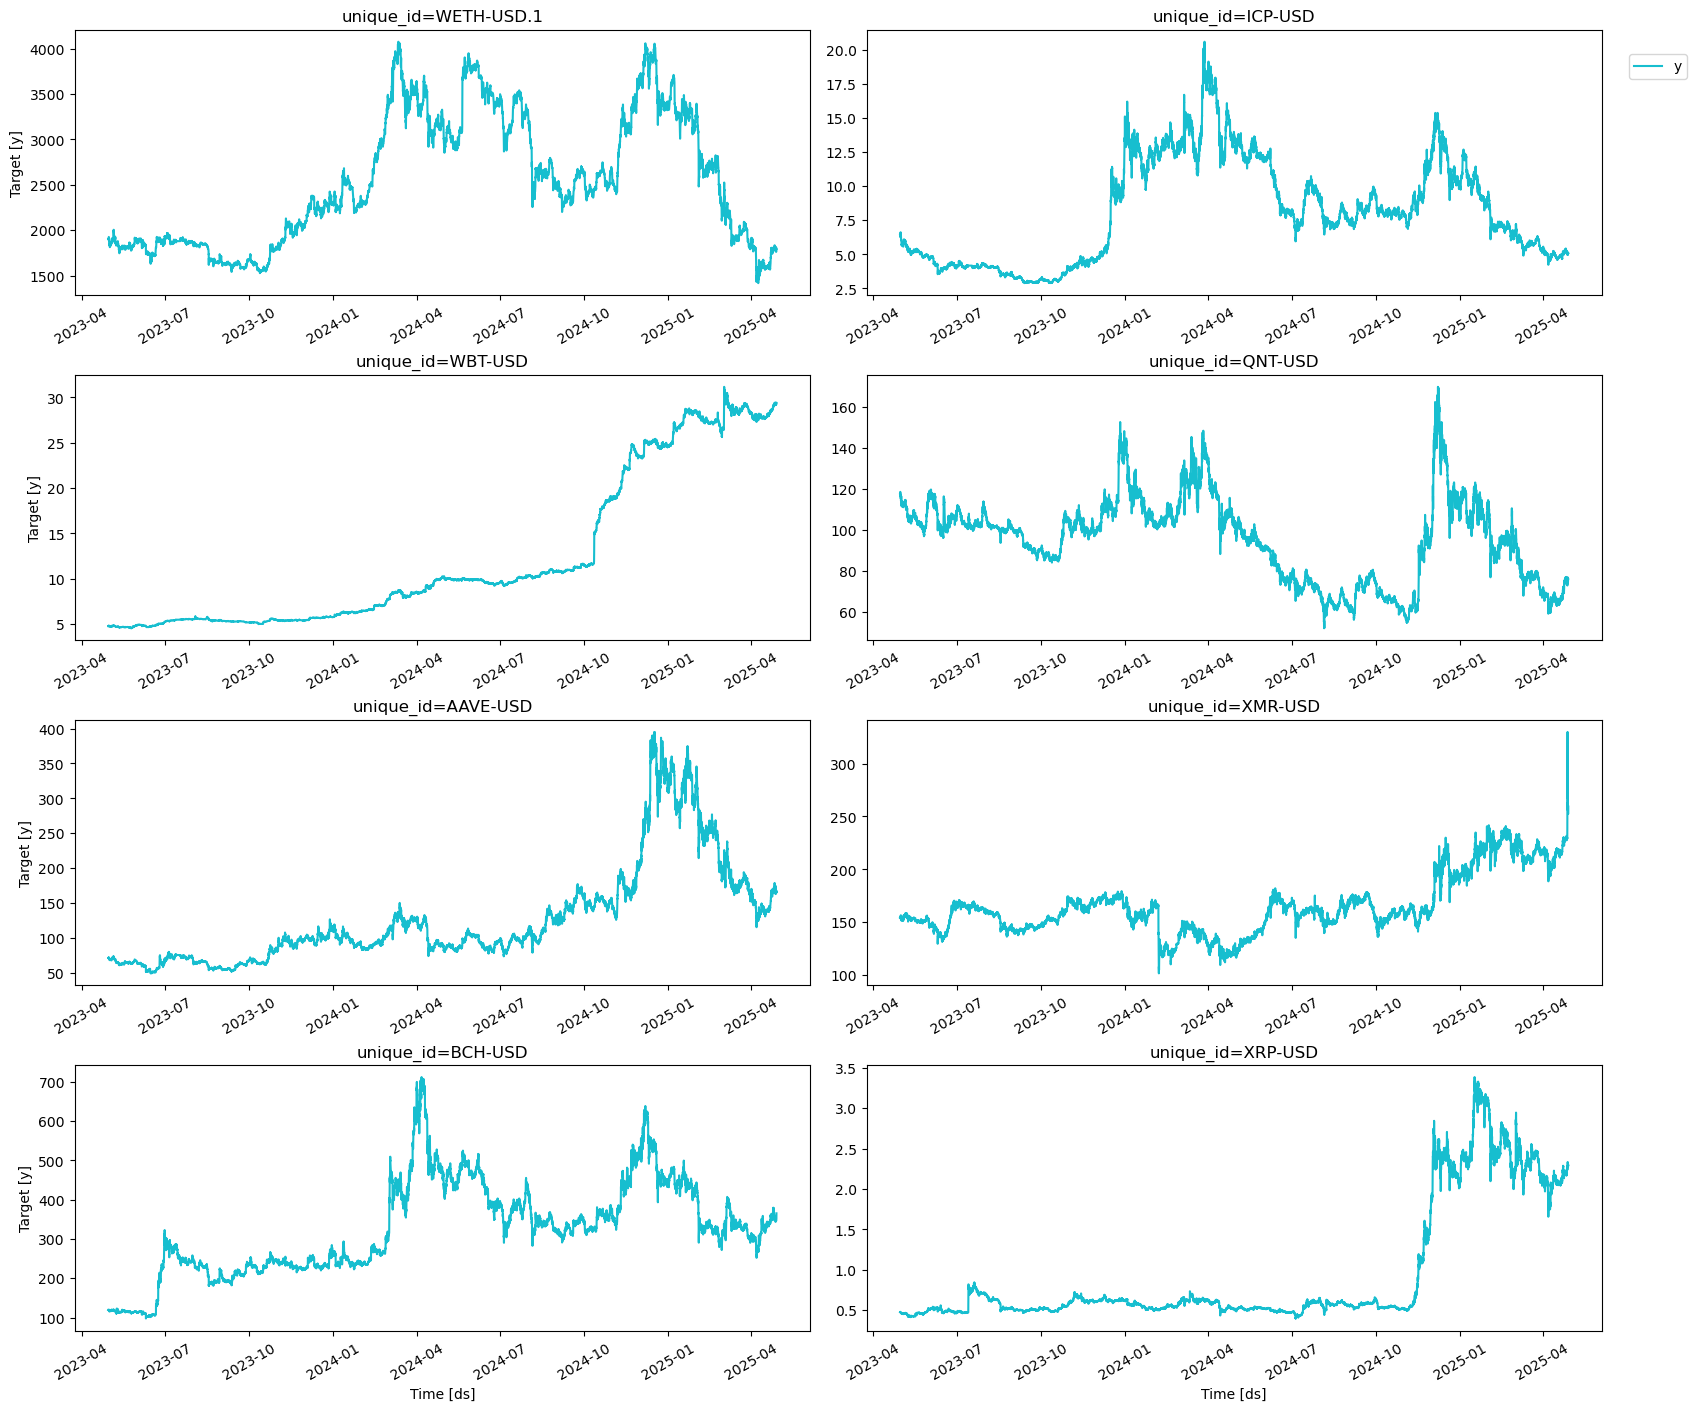

In [8]:
plot_series(Y_df)

In [22]:
import neuralforecast.auto
from neuralforecast.auto import AutoNHITS, AutoRNN, AutoLSTM, AutoGRU, AutoTCN, AutoDeepAR, AutoDilatedRNN, AutoBiTCN
from neuralforecast.auto import AutoMLP, AutoNBEATS, AutoNBEATSx, AutoDLinear, AutoNLinear, AutoTiDE, AutoDeepNPTS
from neuralforecast.auto import AutoTFT, AutoVanillaTransformer, AutoInformer, AutoAutoformer, AutoFEDformer
from neuralforecast.auto import AutoPatchTST, AutoiTransformer, AutoTimesNet

horizont = 1

# --- CONFIGS ---

# Extract the default hyperparameter settings

#A. RNN-Based
rnn_config = AutoRNN.get_default_config(h = horizont, backend="ray")
lstm_config = AutoLSTM.get_default_config(h = horizont, backend="ray")
gru_config = AutoGRU.get_default_config(h = horizont, backend="ray")
tcn_config = AutoTCN.get_default_config(h = horizont, backend="ray")
deep_ar_config = AutoDeepAR.get_default_config(h = horizont, backend="ray")
dilated_rnn_config = AutoDilatedRNN.get_default_config(h = horizont, backend="ray")
bitcn_config = AutoBiTCN.get_default_config(h = horizont, backend="ray")

#B. MLP-Based
mlp_config = AutoMLP.get_default_config(h = horizont, backend="ray")
nbeats_config = AutoNBEATS.get_default_config(h = horizont, backend="ray")
nbeatsx_config = AutoNBEATSx.get_default_config(h = horizont, backend="ray")
nhits_config = AutoNHITS.get_default_config(h = horizont, backend="ray")
dlinear_config = AutoDLinear.get_default_config(h = horizont, backend="ray")
nlinear_config = AutoNLinear.get_default_config(h = horizont, backend="ray")
tide_config = AutoTiDE.get_default_config(h = horizont, backend="ray")
deep_npts_config = AutoDeepNPTS.get_default_config(h = horizont, backend="ray")

#C. Transformer models
tft_config = AutoTFT.get_default_config(h = horizont, backend="ray")
vanilla_config = AutoVanillaTransformer.get_default_config(h = horizont, backend="ray")
informer_config = AutoInformer.get_default_config(h = horizont, backend="ray")
autoformer_config = AutoAutoformer.get_default_config(h = horizont, backend="ray")
fedformer_config = AutoFEDformer.get_default_config(h = horizont, backend="ray")
patch_tst_config = AutoPatchTST.get_default_config(h = horizont, backend="ray")

itransformer_config = AutoiTransformer.get_default_config(h = horizont, n_series=1, backend="ray")

#D. CNN Based
timesnet_config = AutoTimesNet.get_default_config(h = horizont, backend="ray")

In [24]:
# --- MODELS ---
#A. RNN-Based
rnn_model = AutoRNN(h=horizont, config=rnn_config, verbose=False)
lstm_model = AutoLSTM(h=horizont, config=lstm_config, verbose=False)
gru_model = AutoGRU(h=horizont, config=gru_config, verbose=False)
tcn_model = AutoTCN(h=horizont, config=tcn_config, verbose=False)
deep_ar_model = AutoDeepAR(h=horizont, config=deep_ar_config, verbose=False)
dilated_rnn_model = AutoDilatedRNN(h=horizont, config=dilated_rnn_config, verbose=False)
bitcn_model = AutoBiTCN(h=horizont, config=bitcn_config, verbose=False)

#B. MLP-Based
mlp_model = AutoMLP(h=horizont, config=mlp_config, verbose=False)
nbeats_model = AutoNBEATS(h=horizont, config=nbeats_config, verbose=False)
nbeatsx_model = AutoNBEATSx(h=horizont, config=nbeats_config, verbose=False)
nhits_model = AutoNHITS(h=horizont, config=nhits_config, verbose=False)
dlinear_model = AutoDLinear(h=horizont, config=dlinear_config, verbose=False)
nlinear_model = AutoNLinear(h=horizont, config=nlinear_config, verbose=False)
tide_model = AutoTiDE(h=horizont, config=tide_config, verbose=False)
deep_npts_model = AutoDeepNPTS(h=horizont, config=deep_npts_config, verbose=False)

#C. Transformer models
tft_model = AutoTFT(h=horizont, config=tft_config, verbose=False)
vanilla_model = AutoVanillaTransformer(h=horizont, config=vanilla_config, verbose=False)
informer_model = AutoInformer(h=horizont, config=informer_config, verbose=False)
autoformer_model = AutoAutoformer(h=horizont, config=autoformer_config, verbose=False)
fedformer_model = AutoFEDformer(h=horizont, config=fedformer_config, verbose=False)
patch_tst_model = AutoPatchTST(h=horizont, config=patch_tst_config, verbose=False)

itransformer_model = AutoiTransformer(h=horizont, n_series=1, config=itransformer_config, verbose=False)

#D. CNN Based
timesnet_model = AutoTimesNet(h=horizont, config=timesnet_config, verbose=False)

In [11]:
MODEL_NAMES = [
    # 'lstm',
    # 'gru',
    # 'mlp',
    # 'dlinear',
    # 'nlinear',
    # 'informer',
    # 'autoformer',
    # 'fedformer',
    'bitcn',
    'rnn',

    'tcn',
    'deep_ar',
    'dilated_rnn',
    #nbeats,
    #nbeatsx,
    'nhits',
    'tide',
    'deep_npts',
    'tft',
    'vanilla',
    'patch_tst',
    'itransformer'
]

In [12]:
models = [
    # lstm_model,
    # gru_model,
    # mlp_model,
    # dlinear_model,
    # nlinear_model,
    # informer_model,
    # autoformer_model,
    # fedformer_model,
    bitcn_model,
    rnn_model,

    tcn_model,
    deep_ar_model,
    dilated_rnn_model,
    #nbeats,
    #nbeatsx,
    nhits_model,
    tide_model,
    deep_npts_model,
    tft_model,
    vanilla_model,
    patch_tst_model,
    itransformer_model
]

In [ ]:
# %%time
# # training each model individually
# import logging

# # Configure logging
# logging.basicConfig(filename='cross_logs.txt', level=logging.INFO, filemode='w')

# h = horizont
# n_windows=5888
# #refit=False
# refit=24*30 #refit every 30 days
# nfs = []
# cv_dfs = []

# for model in models:
#     logging.info(f"Starting cross validation for model {type(model)}")
#     nf = NeuralForecast(models=[model], freq='h');

#     try:
#       cv_df = nf.cross_validation(Y_df, n_windows=n_windows, step_size=h, refit=refit)
#       cv_dfs.append(cv_df)
#       nfs.append(nf)
#       logging.info(f"Finished cross validation of model {type(model)}")
#     except Exception as e:
#       logging.error(f"Error in cross validation for model {type(model)}: {e}")

In [13]:
#folder = './datasets/crypto/hourly/'
cross_folder = folder + '/cross-validation/plain'
refit_folder = folder + '/cross-validation/refit'
output_folder = refit_folder
model_folder = '/models/'
forecast_folder = '/forecasts/'

os.makedirs(output_folder + forecast_folder, exist_ok=True)

# for i in range(len(models)):
#     nfs[i].save(output_folder + model_folder + MODEL_NAMES[i].lower(), overwrite=True)
#     cv_dfs[i].to_csv(output_folder + forecast_folder + MODEL_NAMES[i] + '.csv', index=False)

In [14]:
%%time
# training each model individually
import logging

# Configure logging
logging.basicConfig(filename='cross_logs.txt', level=logging.INFO, filemode='w')

h = horizont
n_windows=5888
#refit=False
refit=24*30 #refit every 30 days
nfs = []
cv_dfs = []

# for model in models:
for i in range(len(models)):
    logging.info(f"Starting cross validation for model {type(models[i])}")
    nf = NeuralForecast(models=[models[i]], freq='h');

    try:
      cv_df = nf.cross_validation(Y_df, n_windows=n_windows, step_size=h, refit=refit)
      cv_dfs.append(cv_df)
      nfs.append(nf)
      nfs[i].save(output_folder + model_folder + MODEL_NAMES[i].lower(), overwrite=True)
      cv_dfs[i].to_csv(output_folder + forecast_folder + MODEL_NAMES[i] + '.csv', index=False)
      logging.info(f"Finished cross validation of model {type(models[i])}")
    except Exception as e:
      logging.error(f"Error in cross validation for model {type(models[i])}: {e}")

2025-05-09 18:40:52,892	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_ec081_00000
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ray/_private/worker.py", line 2771, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ray/_private/worker.py", li

CPU times: user 3h 30min 47s, sys: 27min 20s, total: 3h 58min 7s
Wall time: 4h 47min 24s


(raylet) [2025-05-09 18:41:46,719 E 477 477] (raylet) node_manager.cc:3219: 27 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e240cfa718e0e51154356659d27ec1ae5661e6dc47294f7d32bb1dc8, IP: 172.18.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.18.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [15]:
import IPython
IPython.display.Audio("file_example_MP3_1MG.mp3", autoplay=True)

In [ ]:
%%time
# training all models together
h = horizont
n_windows=5888

nf = NeuralForecast(models=models, freq='h');
cv_df = nf.cross_validation(Y_df, n_windows=n_windows, step_size=h)

nf.save(cross_folder + model_folder + 'ALL', overwrite=True)
cv_df.to_csv(cross_folder + forecast_folder + 'ALL.csv', index=False)

cv_df

In [ ]:
cutoffs = cv_df['cutoff'].unique()

model_name = 'AutoLSTM'

plt.figure(figsize=(15,5))
plt.xlim('2024-08-26 17:00:00', '2025-04-29 00:00:00')
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df['ds'], ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()

In [ ]:
# cv_df_val_test = nf.cross_validation(Y_df, val_size=2000, test_size=200, step_size=h, n_windows=None)

In [ ]:
# cutoffs = cv_df_val_test['cutoff'].unique()
# plt.figure(figsize=(15,5))

# # Plot the original data and NHITS predictions
# plt.plot(Y_df['ds'], Y_df['y'])
# plt.plot(cv_df_val_test['ds'], cv_df_val_test[model_name], label=model_name, ls='--')

# # Add highlighted areas for validation and test sets
# plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[499], alpha=0.2, color='yellow', label='Validation Set')
# plt.axvspan(Y_df['ds'].iloc[500], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')

# # Add vertical lines for cutoffs
# for cutoff in cutoffs:
#     plt.axvline(x=cutoff, color='black', ls=':')

# # Set labels and legend
# plt.xlabel('Time steps')
# plt.ylabel('Target [H1]')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
%%time
refit=24*7 # refit every week
cv_df_refit = nf.cross_validation(Y_df, n_windows=n_windows, step_size=h, refit=refit)

In [ ]:
cutoffs = cv_df_refit['cutoff'].unique()

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_refit['ds'], cv_df_refit[model_name], label=model_name, ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()

In [ ]:
Pó Pará

In [ ]:
%%time
cv_df_refit_overlap = nf.cross_validation(Y_df, n_windows=2, step_size=h, refit=refit)

In [ ]:
cutoffs[0]

In [ ]:
cutoffs

In [ ]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()

fold1 = cv_df_refit_overlap.query(cutoffs[0].strftime('%Y-%m-%d %H:%M:%S'))
fold2 = cv_df_refit_overlap.query(cutoffs[1].strftime('%Y-%m-%d %H:%M:%S'))

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(fold1['ds'], fold1[model_name], label=model_name+' (fold 1)', ls='--', color='blue')
plt.plot(fold2['ds'], fold2[model_name], label=model_name+' (fold 2)', ls='-.', color='red')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
#plt.ylabel('Target [H1]')
plt.xlim(500, 700)
plt.legend()
plt.tight_layout()